In [4]:
pip install imblearn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 57.3 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 58.8 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
import seaborn as sns

In [25]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("loan_default_modeling")


2025/04/17 22:06:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/04/17 22:06:36 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/loan-default-modeling/mlruns/1', creation_time=1744927597333, experiment_id='1', last_update_time=1744927597333, lifecycle_stage='active', name='loan_default_modeling', tags={}>

In [ ]:
#mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts

In [6]:
df=pd.read_csv("cleaned_data/train.csv")

In [7]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,...,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,AGE_AT_DISBURSAL,EMP_Salaried,EMP_Self employed,EMP_unknown
0,420825,50578,58400,89.55,67,1,1,0,0,0,...,0,0,0,0,0,0,34,1,0,0
1,537409,47145,65550,73.23,67,1,1,0,0,0,...,0,1,695,695,0,1,33,0,1,0
2,417566,53278,61360,89.63,67,1,1,0,0,0,...,0,0,0,0,0,0,32,0,1,0
3,624493,57513,66113,88.48,67,1,1,0,0,0,...,0,0,240,455,1,1,24,0,1,0
4,539055,52378,60300,88.39,67,1,1,0,0,0,...,0,0,0,0,1,1,40,0,1,0


In [17]:
print(df.groupby('LOAN_DEFAULT').count()['UNIQUEID'].reset_index())

   LOAN_DEFAULT  UNIQUEID
0             0    182543
1             1     50611


In [12]:
df.columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG',
       'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT', 'AGE_AT_DISBURSAL', 'EMP_Salaried', 'EMP_Self employed',
       'EMP_unknown'],
      dtype='object')

In [14]:
df.shape

(233154, 37)

In [21]:
y=df['LOAN_DEFAULT']
X=df.drop('LOAN_DEFAULT',axis=1)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [23]:
smote=SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [26]:
def plot_confusion_matrix(y_true,y_pred):
  cm=confusion_matrix(y_true,y_pred)
  labels=['no_default 0','default 1']
  sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
  plt.title('confusion matrix')
  plt.ylabel("actual label")
  plt.xlabel("predicted label")
  print("True Negative :",cm[0][0])
  print("False Positive :",cm[0][1])
  print("False Negative :",cm[1][0])
  print("True Positive :",cm[1][1])
  print('total :',np.sum(cm[1]))

2025/04/17 22:35:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


True Negative : 34552
False Positive : 1957
False Negative : 9046
True Positive : 1076
total : 10122


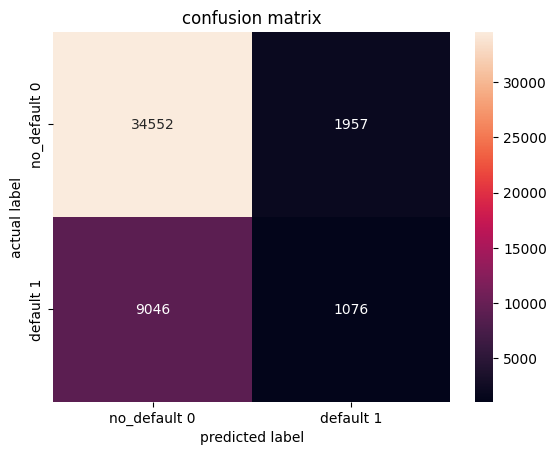

In [38]:
#Random forest classifier
with mlflow.start_run(run_name="randomforest_runs")as run:
    params=dict(max_depth=20,n_estimators=100,random_state=42)
    mlflow.log_params(params)
    rf_model=RandomForestClassifier(**params)
    rf_model.fit(X_train_resampled,y_train_resampled)
    rf_pred=rf_model.predict(X_test)
    #log model
    mlflow.sklearn.log_model(rf_model,"random_forest_model")
    report_dict = classification_report(y_test, rf_pred, output_dict=True)
    # Log individual metrics (e.g., accuracy, precision, recall, etc.)
    mlflow.log_metrics({
        "precision": report_dict["weighted avg"]["precision"],
        "recall": report_dict["weighted avg"]["recall"],
        "f1_score": report_dict["weighted avg"]["f1-score"],
        "accuracy": report_dict["accuracy"]
    })
    plot_confusion_matrix(y_test,rf_pred)